# SLT-CE-2: Sampling

# Introduction

## Task

In this coding exercise we will test various MCMC sampling procedures [1] introduced during the tutorial session. We will try to solve the image reconstruction problem. Given a noisy [binary image](https://en.wikipedia.org/wiki/Binary_image) one needs to recover the original through denoising. To do so we will use the prototypical [Ising model](https://en.wikipedia.org/wiki/Ising_model) from physics as explained in section 8.3.3 of [2]. An undirected graphical model is designed to model (i) the adherence of the reconstruction to the observed noisy image and (ii) the correlation between neighboring pixels. We are interested in recovering a single image, the most likely one, with respect to the underlying distribution i.e. we do MAP inference to discover the peak of the posterior distribution $p(image\_reconstruction | noisy\_observation)$.


### References 

[1] http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf

[2] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

## Model

Given a noisy, binary image $y=(y_1,\dots,y_n)$ where $y_i\in\{\pm1\}$ is the value of the i-th pixel, the Ising model tries to find a denoised image $x=(x_1,\dots,x_n)$ by minimizing the following energy function:

$$E(x,y) = - h \sum_{i} x_i - \beta \sum_{i,j \in N_i} x_i x_j - \eta \sum_{i} x_i y_i$$

where $N_i$ is the set of neighbors of pixel $i$. For a 2D image the pixel neighbourhood $N_i$ usually involves 4 or 8 surrounding pixels. You should try out both options during this exercise, and see which one works better. The undirected probabilistic graphical model from where the energy function $E(x,y)$ is derived is in more detail explained in [2].

## Setup

We start by importing necessary python packages.

In [1]:
import matplotlib.image as mpimg
import numpy as np
import random as rd
import matplotlib.pylab as plt
from scipy.ndimage import convolve
import time

We load the original image of size 300x300 which we will be trying to reconstruct. White pixels have values -1 and the black pixels are of value +1.

In [2]:
IMG_ORIGINAL = mpimg.imread("flower.png")#[:,:,0]/255
IMG_ORIGINAL[IMG_ORIGINAL > 0.5] = 1
IMG_ORIGINAL[IMG_ORIGINAL <= 0.5] = -1

Check the dimensions of the image

In [3]:
IMG_HEIGHT = IMG_ORIGINAL.shape[0]
IMG_WIDTH = IMG_ORIGINAL.shape[1]
IMG_ORIGINAL.shape

(300, 300)

Plot the original image

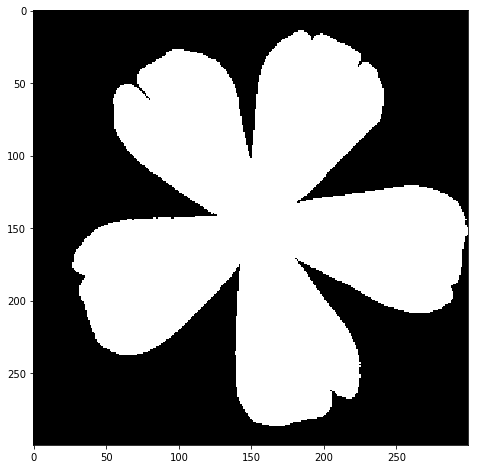

In [4]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_ORIGINAL, cmap='gray')
plt.show()

Generate the noisy version - flip random 30% of pixels. 

In [5]:
# Fix random seed for reproducibility
np.random.seed(13)

IMG_NOISY_OBSERVATION = IMG_ORIGINAL.copy()
num_flips = int(0.3 * IMG_HEIGHT * IMG_WIDTH)

perm = np.random.permutation(IMG_ORIGINAL.size)[0:int(0.3 * IMG_ORIGINAL.size)]
for k in perm:
    i = int(k/IMG_WIDTH)
    j = k%IMG_HEIGHT
    IMG_NOISY_OBSERVATION[i,j] = -IMG_NOISY_OBSERVATION[i,j]

Plot the noisy version of the original image

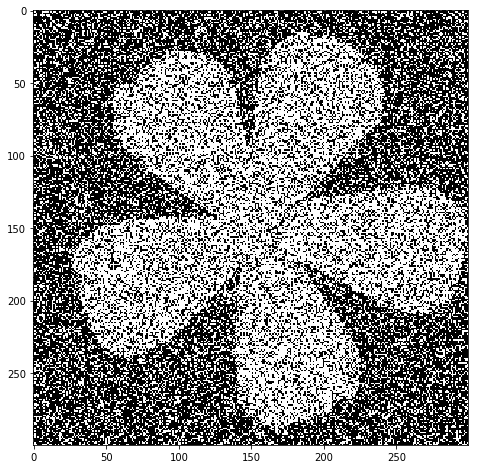

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_NOISY_OBSERVATION, cmap='gray')
plt.show()

Finally, in this exercise we do not care about learning the right model from the data, but only about inferring the most likely state, the one with the minimum energy. Thus we will fix parameters of the model as given in [2].

In [7]:
H = 0.0
Beta = 1.0
Eta = 2.1

# Problems:

Solve all the problems to get 1 point, and an extension at the end of the notebook to get an extra point. Note that above all, we will validate the working code. If most of the exercise is successfully completed you will be fully compensated. In addition, make sure that all the code can be executed in a reasonable time meaning approx. less than 2mins, otherwise you might want to do some changes in your implementation.

## Problem 0

Shortly describe, in a few sentences, and give the corresponding formulas for the following sampling procedures which you will be consequently trying to implement in the rest of this exercise. Add text in each bullet. See [markdown cheatsheet](https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed) for text editing.
- Metropolis:
- Heathbath:
- Simulated Annealing:
- Parallel Tempering

## Metropolis
Initialization: Choose an arbitrary point x0 to be the first sample <br>
For each iteration t: 
- Generate : Generate a candidate x in a random walk through the image and flip the sign of the corresponding pixel. Another option could be to iterate in an ordered fashion through the image i.e. start at the top left corner and proceed row by row. <br>
- Calculate : Calculate the acceptance ratio α = exp[-Beta\* max(0, E(x',y)-E(xt,y))], which will be used to decide whether to accept or reject the candidate. Because exp[-Beta\* E(x',y)] is proportional to the density of P, we have that α=P(x′)/ P(xt). <br>
- Accept or Reject: Generate a uniform random number u on [0,1]. <br>
If u ≤ α: accept the candidate by setting x\_(t+1) = x′ <br>
If u > α: reject the candidate and set x\_(t+1) = xt instead. <br>

## Heathbath
Same as Metropolis sampler except that the acceptance ration is defined differently: α = 1/2* [1- tanh(1/2 Beta** (E(x',y)-E(xt,y)))] <br>

## Simulated Annealing
The name and inspiration come from annealing in metallurgy, a technique involving heating and controlled cooling of a material to increase the size of its crystals and reduce their defects. Both are attributes of the material that depend on its thermodynamic free energy. Heating and cooling the material affects both the temperature and the thermodynamic free energy. The simulation of annealing can be used to find an approximation of a global minimum for a function with a large number of variables to the statistical mechanics of equilibration (annealing). <br>

Initialise: Pick an initial state x0 and initial temperature T0 <br>
For each iteration t: 
- Generate: randomly generate a candidate state x' in a random walk and switch the sign of the corresponding pixel <br>
- Calculate: calculate the acceptance ratio α = exp[-Beta(T)\* max(0, E(x',y)-E(xt,y))] <br>
- Accept or Reject: Generate a uniform random number u on [0,1]. <br>
If u ≤ α: accept the candidate by setting x\_(t+1)=x′ <br>
If u > α: reject the candidate and set x\_(t+1) = xt instead. <br>
- Update: Update temperature by some update law <br>

## Parallel Tempering
Essentially, one runs N copies of the system, randomly initialized, at different temperatures. Then, based on the Metropolis criterion one exchanges configurations at different temperatures. The idea of this method is to make configurations at high temperatures available to the simulations at low temperatures and vice versa. This results in a very robust ensemble which is able to sample both low and high energy configurations which helps to escape local minima. The key insight is that the temperature influences the resolution of the free energy space and therefore replica at different temperatures expierience a different "topology".

Initialization: Choose an arbitrary point x0 to be the first sample <br>
For each iteration t: 
- Generate : Generate a candidate x in a random walk through the image and flip the sign of the corresponding pixel. Another option could be to iterate in an ordered fashion through the image i.e. start at the top left corner and proceed row by row. <br>
    For each replica R:
    - Calculate : Calculate the acceptance ratio α = exp[-Beta\* max(0, E(x',y)-E(xt,y))], which will be used to decide whether to accept or reject the candidate. Because exp[-Beta\* E(x',y)] is proportional to the density of P, we have that α=P (x′)/P(xt). <br>
    - Accept or Reject: Generate a uniform random number u on [0,1]. <br>
    If u ≤ α: accept the candidate by setting x_(t+1)=x′ <br>
    If u > α: reject the candidate and set x_(t+1) = xt instead. <br>
- Choose: choose random replica R\_i
- Calculate: calculate acceptance probability of replica exchange  α = min[1, exp{(E(R\_i- E(R\_(i+1))* (Beta(R\_i)- Beta(R\_(i+1))}]
- Accept or Reject: Generate a uniform random number u on [0,1]. <br>
    If u ≤ α: accept the exchange by setting R_\i= R\_(i+1) and vice versa <br>
    If u > α: reject the exchange. <br>

In [8]:
## Problem 1

Firstly, to be able to search for the state which minimizes the energy of our model, we need to be able to compute the energy. This is done with respect to the model described at the beginning of the notebook. We also want to have a certain quantification of our reconstruction, to measure how far is our reconstruction estimate from the original. For this, we will use [Mean Squared Error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error). Implement the two following functions. Also feel free to add any additional auxilary functions which will be used in the rest of the exercise.

SyntaxError: invalid syntax (<ipython-input-8-c4e3ba6302db>, line 3)

In [9]:
def energy(img_estimate, img_noisy_observation, n_neighbors):
    """Compute the energy for given estimate 'img_estimate' which
    is our vector x in the original model, with respect to the 
    observation 'img_noisy_observation', vector y in the model.

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
            energy (float): energy of the estimate given observation
    """
    
    # extract image dimensions
    Ny, Nx = img_estimate.shape
    
    # calculate energy (part 1)
    energy = -H* np.sum(img_estimate.reshape(-1, 1))- Eta* np.dot(img_estimate.reshape(1, -1), img_noisy_observation.reshape(-1, 1))
    
    # loop over vertical dimension
    for i in range(Ny):
        
        # loop over horizontal dimension
        for j in range(Nx):
               
            # determine neighbors of current point
            neigh = neighbors(i, j, Nx, Ny, n_neighbors)
                
            # calculate energy (part 2)
            for n in neigh:
                energy-= Beta* img_estimate[i, j]* img_estimate[int(n[0]), int(n[1])]
                          
    return energy[0]

In [10]:
def mse_loss(img_estimate, img_original):
    """Computing mean squared error loss

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_original (np.ndarray): original image matrix

    Returns:
            mse (float): mean squared error between two matrices
    """
    
    # initialize means squared error
    mse = 0
    
    # reshape image
    img_est = img_estimate.reshape(-1, 1)
    img_org = img_original.reshape(-1, 1)
    
    # loop over reshaped image and calc MSE
    for i in range(len(img_est)):
        mse+= (img_est[i]- img_org[i])**2
        
    # take square root of MSE
    mse = np.sqrt(mse)
        
    return mse

In [11]:
# Any auxiliary functions may be placed here..
def neighbors(i, j, Nx, Ny, n_neighbors):
    # (i, j): cell indices
    # (Ny, Nx): image dimensions
    # n_neighbors: number of neighbors considered
    
    # initialize array for neighbors
    neighbors = np.empty([0, 2])
    
    # loop over neighborhood
    for k in [-1, +1]:
        
        #  1 2 3
        #  4 5 6
        #  7 8 9
           
        # 2, 8
        if i+k>= 0 and i+k <Ny:
            neighbors = np.append(neighbors, np.array([[i+k, j]]), axis = 0)
            
            if n_neighbors == 8:
                # 3, 7
                if j+k>= 0 and j+k <Nx:
                    neighbors = np.append(neighbors, np.array([[i+k, j+k]]), axis = 0)
                    
                # 1, 9
                if j-k>= 0 and j-k <Nx:
                    neighbors = np.append(neighbors, np.array([[i+k, j-k]]), axis = 0) 
                    
        # 4, 6
        if j+k>= 0 and j+k <Nx:
            neighbors = np.append(neighbors, np.array([[i, j+k]]), axis = 0)

    return neighbors
    
    

Display various energies and losses for the noisy image as our initial estimate with respect to the original image.

In [12]:
print(mse_loss(IMG_NOISY_OBSERVATION, IMG_ORIGINAL))
print(energy(IMG_ORIGINAL, IMG_NOISY_OBSERVATION, n_neighbors= 4))
print(energy(IMG_NOISY_OBSERVATION, IMG_NOISY_OBSERVATION, n_neighbors= 4))

[328.63354]
[-426700.]
[-245999.98]


## Problem 2

Implement metropolis sampling.

In [13]:
def metropolis(img_noisy_observation, img_original, epochs, n_neighbors):
    """Do the metropolis sampling starting from noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    # initialize
    x = img_noisy_observation.copy()
    x_new = img_noisy_observation.copy()
    
    # image size
    Ny, Nx = x.shape
    
    # energies
    energies = []
    e_tracking = energy(x, img_noisy_observation, n_neighbors)
    
    # losses
    losses = []
    
    # sampling       
    for k in range(epochs):
        
        # introduce random walk through image
        perm = np.random.permutation(x.size)[0:int(0.6 * x.size)]
        
        for it, p in enumerate(perm):
            i = int(p/ Nx)
            j = p% Ny
                     
            # switch pixels
            x_new[i, j] = -x_new[i, j]    
            
            # calculate neighbors
            neigh = neighbors(i, j, Nx, Ny, n_neighbors)
            min_x = int(np.min(neigh[:, 1]))
            max_x = int(np.max(neigh[:, 1]))
            
            min_y = int(np.min(neigh[:, 0]))
            max_y = int(np.max(neigh[:, 0]))
            
            # local energy calculation
            e1 = energy(x[min_y: max_y, min_x: max_x], img_noisy_observation[min_y: max_y, min_x: max_x], n_neighbors)
            e2 = energy(x_new[min_y: max_y, min_x: max_x], img_noisy_observation[min_y: max_y, min_x: max_x], n_neighbors)
                
            # acceptance probability            
            prob = np.exp(-Beta* max(0, e2-e1))
                
            u= rd.random()
                
            if prob >= u:
                x[i, j] = x_new[i, j]                
                e_tracking = e_tracking + e2 - e1
            else:
                x_new[i, j] = x[i, j]
                
            # calculate total energy every nth iteration    
            if (it)%25000 == 0:
                energies.append(e_tracking)
                losses.append(mse_loss(x, img_original))
    
    return x, np.asarray(energies), np.asarray(losses)



## Problem 3

Implement heath bath sampling.

In [14]:
def heathbath(img_noisy_observation, img_original, epochs, n_neighbors):
    """Do the heath bath sampling starting from noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    
    # initialize
    x = img_noisy_observation.copy()
    x_new = img_noisy_observation.copy()
    
    # image size
    Ny, Nx = x.shape
    
    # energies
    energies = []
    e_tracking = energy(x, img_noisy_observation, n_neighbors)
    
    # losses
    losses = []
    
    # sampling       
    for k in range(epochs):
        
        # introduce random walk through image
        perm = np.random.permutation(x.size)[0:int(0.6 * x.size)]
        
        for it, p in enumerate(perm):
            i = int(p/ Nx)
            j = p% Ny
                
            # switch pixels
            x_new[i,j] = -x_new[i,j]      
            
            # calculate neighbors
            neigh = neighbors(i, j, Nx, Ny, n_neighbors)
            min_x = int(np.min(neigh[:, 1]))
            max_x = int(np.max(neigh[:, 1]))
            
            min_y = int(np.min(neigh[:, 0]))
            max_y = int(np.max(neigh[:, 0]))
            
            # local energy calculation
            e1 = energy(x[min_y: max_y, min_x: max_x], img_noisy_observation[min_y: max_y, min_x: max_x], n_neighbors)
            e2 = energy(x_new[min_y: max_y, min_x: max_x], img_noisy_observation[min_y: max_y, min_x: max_x], n_neighbors)
                
            # acceptance probability 
            prob = 1/2* (1- np.tanh(Beta/2* (e2-e1)))
                
            u= rd.random()
                
            if prob >= u:
                x[i, j] = x_new[i, j]                
                e_tracking = e_tracking + e2 - e1
            else:
                x_new[i, j] = x[i, j]
              
            # calculate total energy every nth iteration
            if (it)%25000 == 0:
                energies.append(e_tracking)
                losses.append(mse_loss(x, img_original))
    
    return x, np.asarray(energies), np.asarray(losses)

## Problem 4

Implement simulated annealing.

In [15]:
def simulated_annealing(img_noisy_observation, img_original, epochs, n_neighbors):
    """Do the simulated annealing sampling starting from noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    
    # initialize
    x = img_noisy_observation.copy()
    x_new = img_noisy_observation.copy()
    
    # image size
    Ny, Nx = x.shape
    
    # energies
    energies = []
    e_tracking = energy(x, img_noisy_observation, n_neighbors)
    
    # losses
    losses = []
    
    # changing temperature (via Beta coefficient)
    Beta_iter = 2/epochs* Beta
    
    # sampling       
    for k in range(epochs):
        
        # introduce random walk through image
        perm = np.random.permutation(x.size)[0:int(0.6 * x.size)]
        
        for it, p in enumerate(perm):
            i = int(p/ Nx)
            j = p% Ny
                     
            # switch pixels
            x_new[i,j] = -x_new[i,j]    
            
            # calculate neighbors
            neigh = neighbors(i, j, Nx, Ny, n_neighbors)
            min_x = int(np.min(neigh[:, 1]))
            max_x = int(np.max(neigh[:, 1]))
            
            min_y = int(np.min(neigh[:, 0]))
            max_y = int(np.max(neigh[:, 0]))
            
            # local energy calculation
            e1 = energy(x[min_y: max_y, min_x: max_x], img_noisy_observation[min_y: max_y, min_x: max_x], n_neighbors)
            e2 = energy(x_new[min_y: max_y, min_x: max_x], img_noisy_observation[min_y: max_y, min_x: max_x], n_neighbors)
                
            # acceptance probability            
            prob = np.exp(-Beta_iter* max(0, e2-e1))
                
            u= rd.random()
                
            if prob >= u:
                x[i, j] = x_new[i, j]
                e_tracking = e_tracking + e2 - e1
            else:
                x_new[i, j] = x[i, j]
                
            # calculate total energy every nth iteration    
            if (it)%25000 == 0:
                energies.append(e_tracking)
                losses.append(mse_loss(x, img_original))
                
            # linear cooling in temperature
            Beta_iter/= (1- 1/ (0.6 * x.size))
    
    return x, np.asarray(energies), np.asarray(losses)

## Problem 5

Implement parallel tempering

In [16]:
def parallel_tempering(img_noisy_observation, img_original, epochs, n_neighbors):
    """Do the parallel tempering sampling starting from noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """

    # image size
    Ny, Nx = img_noisy_observation.shape
    
    # number of replicas
    n_replicas = 4
    
    # initialize
    x = np.empty([n_replicas, Ny, Nx])
    x_new = np.empty([n_replicas, Ny, Nx])
    
    t_start = time.time()
    
    for k in range(n_replicas):
        x[k, :, :] = img_noisy_observation.copy()
        x_new[k, :, :] = img_noisy_observation.copy()
    
    # energies
    energies = []
    e_tracking = np.zeros([n_replicas])
    e_tracking[:] = energy(x[0], img_noisy_observation, n_neighbors)
        
    # losses
    losses = []
    
    # changing temperature (via Beta coefficient)
    Beta_iter = np.empty([n_replicas])
    
    for n in range(n_replicas):
        Beta_iter[n] = (n+ 1)**2 * Beta
    
    # sampling       
    for k in range(epochs):
        
        # introduce random walk through image
        perm = np.random.permutation(Nx* Ny)[0:int(0.6 * Nx* Ny)]
        
        for it, p in enumerate(perm):
            
            i = int(p/ Nx)
            j = p% Ny
                
            # copy figure and switch pixels XXXX
            # x_new = x.copy()
            
            x_new[:, i, j] = -x_new[:, i, j]  
            
            # calculate neighbors
            neigh = neighbors(i, j, Nx, Ny, n_neighbors)
            min_x = int(np.min(neigh[:,1]))
            max_x = int(np.max(neigh[:,1]))
            
            min_y = int(np.min(neigh[:,0]))
            max_y = int(np.max(neigh[:,0]))
            
            e1_up = np.zeros([n_replicas])
            e2_up = np.zeros([n_replicas])
                    
            u= rd.random()
            
            for n in range(n_replicas):
                # local energy calculation
                e1_up[n] = energy(x[n, min_y: max_y, min_x: max_x], img_noisy_observation[min_y: max_y, min_x: max_x], n_neighbors)
                e2_up[n] = energy(x_new[n, min_y: max_y, min_x: max_x], img_noisy_observation[min_y: max_y, min_x: max_x], n_neighbors)
                
                # acceptance probability            
                prob = np.exp(-Beta_iter[n]* max(0, e2_up[n]- e1_up[n]))
                
                if prob >= u:
                    # if this step is performed, x and x_new are the same
                    x[n, i, j] = x_new[n, i, j]
                    e_tracking[n] = e_tracking[n] + e2_up[n] - e1_up[n]
                else:
                    x_new[n, i, j] = x[n, i, j]
                    
                
            # swaping (one pair at random)
            sw_nr = rd.randint(0, n_replicas-2)
            prob_sw = min(1, np.exp((e_tracking[sw_nr+ 1]- e_tracking[sw_nr])* (Beta_iter[sw_nr+ 1]- Beta_iter[sw_nr])))
                
            u_sw = rd.random()
            
            # if accepted, exchange replicas
            if prob_sw >= u_sw:
                x_temp = x[sw_nr].copy()
                e_temp = e_tracking[sw_nr]
                
                x[sw_nr]  = x[sw_nr+ 1].copy()
                x[sw_nr+ 1] = x_temp.copy()
                    
                e_tracking[sw_nr] = e_tracking[sw_nr+ 1]
                e_tracking[sw_nr+ 1] = e_temp
                                
            # calculate total energy every nth iteration    
            if (it)%25000 == 0:
                energies.append(min(e_tracking))
                losses.append(mse_loss(x[np.argmin(e_tracking)], img_original))
        
    return x[np.argmin(e_tracking)], np.asarray(energies), np.asarray(losses)
    

## Problem 6

We provide you with a function which is used to evaluate the performance of your implementation, both in terms of time efficency and the quality of image reconstruction. In addition, we plot the energy and mean squared error loss recorded during sampling procedure. Make sure your implementation is giving reasonable estimates in a reasonable time.

In [17]:
def evaluate(method, img_noisy_observation, img_original, epochs=1, n_neighbors= 4):
    """ Given a sampling method, we will run the sampling procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
            method (function pointer): sampling method
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
            epochs (int): number of epochs to run the sampling
    """
    # Run specified sampling method
    start_time = time.time()
    img_estimate, energies, losses = method(img_noisy_observation, img_original, epochs, n_neighbors)
    execution_time = time.time() - start_time
    # Plot energy and MSE drop
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    ax1.plot(energies)
    ax1.set_title('Energy Drop')
    ax1.set_xlim(0, int(1.1* len(energies)))
    ax2.plot(losses)
    ax2.set_title('MSE Loss Drop')
    ax2.set_xlim(0, int(1.1* len(losses)))
    ax3.imshow(img_estimate, cmap='gray')
    ax3.set_title('Reconstruction')
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    plt.suptitle("Executed in approx. "+str(int(execution_time)) + " seconds")
    # show plots
    plt.show()

Evaluate metropolis

4 neighbors


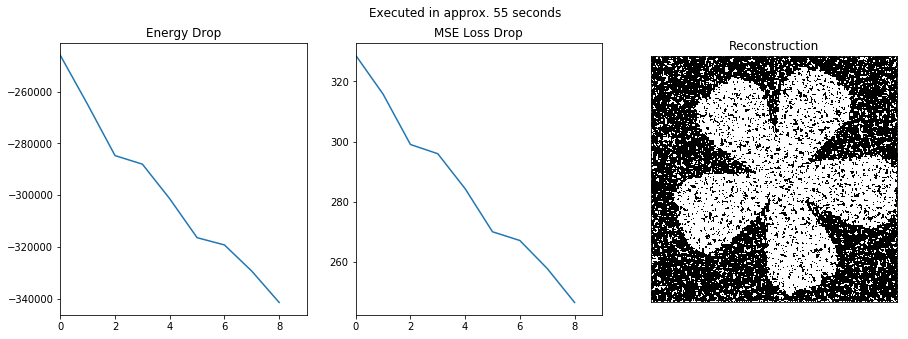

8 neighbors


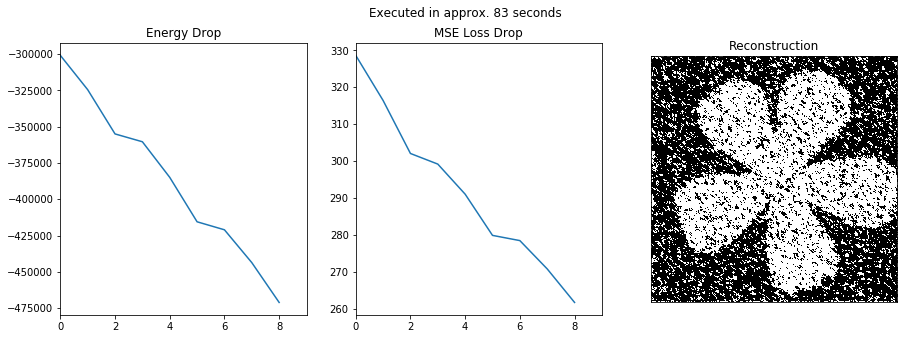

In [18]:
# We selected 5 epochs, but you can lower the number if the execution is slow..
print('4 neighbors')
evaluate(metropolis, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 3)

print('8 neighbors')
evaluate(metropolis, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 3, 8)

Evaluate heathbath

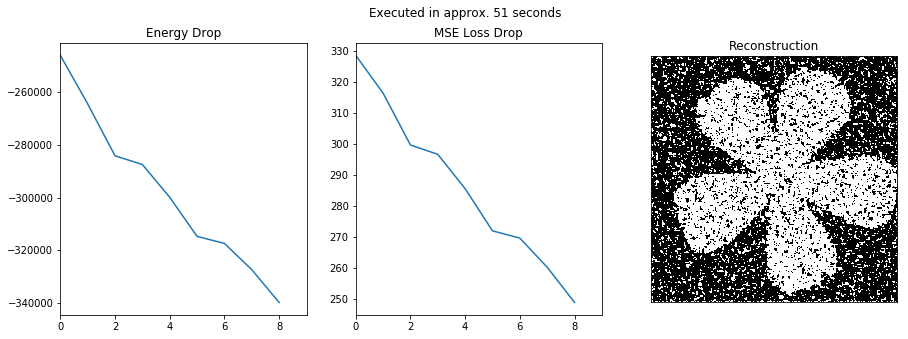

In [19]:
evaluate(heathbath, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 3)

Evaluate simulated annealing

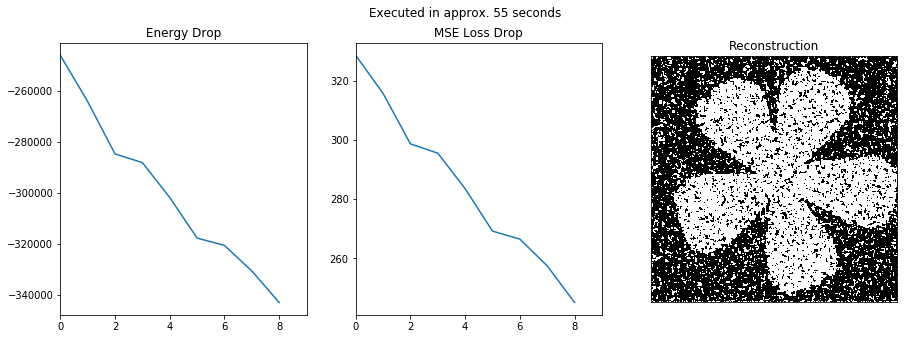

In [20]:
evaluate(simulated_annealing, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 3)

Evaluate parallel tempering

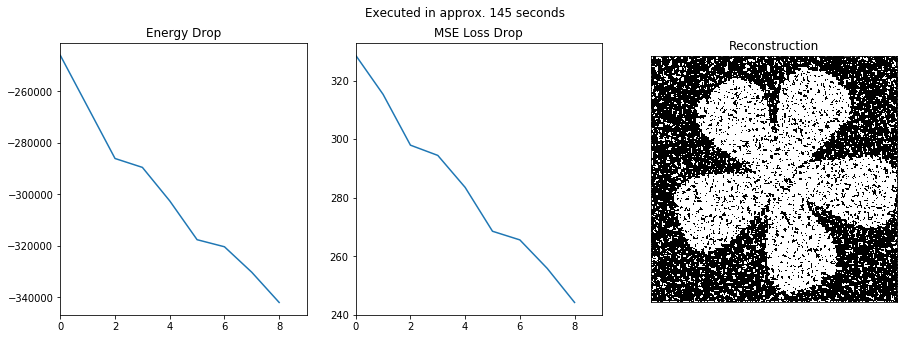

In [21]:
evaluate(parallel_tempering, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 3)

If you have experienced any implementation issues, this is the place to complain. Did you encounter any numerical or efficiency problems? If yes, how did you solve them? Any reasoning is appreciated.

### Your remarks:



In the beginning, I've calculated the energy function for the complete image every iterations. This was very costly and I've quickly realized that it's sufficient to calculate the change in energy in the local neighborhood of the point under consideration.

A further issue was the updating of the images. Initially, I basically copied the image everytime something was modified. Later, I solved this problem by doing local updated i.e. just changing the images at the pixel under consideration.

The number of neighbors were selected as 4 since no significant improvement could be observed for 8 neighbors included measured in terms of MSE. Obviously the energy function will be lower for 8 neighbors since the sum including the neighboring points are larger (8 terms for each point (i,j) compared to 4 points). However, the execution time increase significantly, which led to the choice of just 4 neighbors.

The algorithms perform equally well in terms of RMSE reduction and only slight differences are observed. However, the execution time differs significantly for the parallel tempering since 4 replicas have to be calculated and compared in each iteration.

## Problem 7

We now ask you to re-implement one of the sampling methods of your choice by changing the algorithm slighly (but not only parameters such as e.g. initial temperature $T$). One can for example, in metropolis scheme try to order the evaluated pixels both sequentually and randomly. Also one can implement the simulated annealing with different annealing schedules: logarithmic, linear, quadratic etc. Explain what you change.

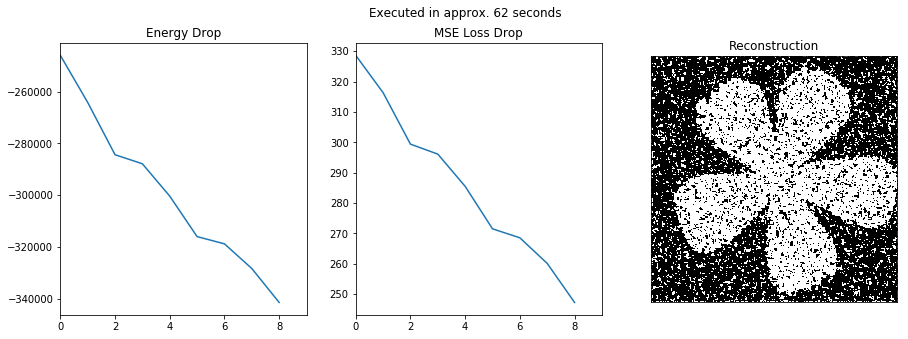

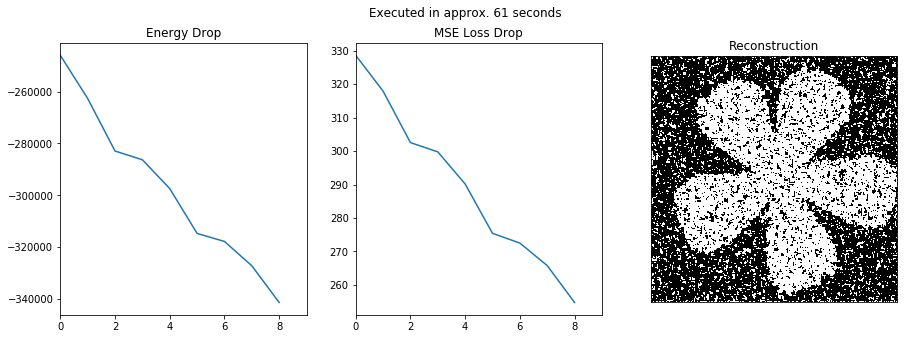

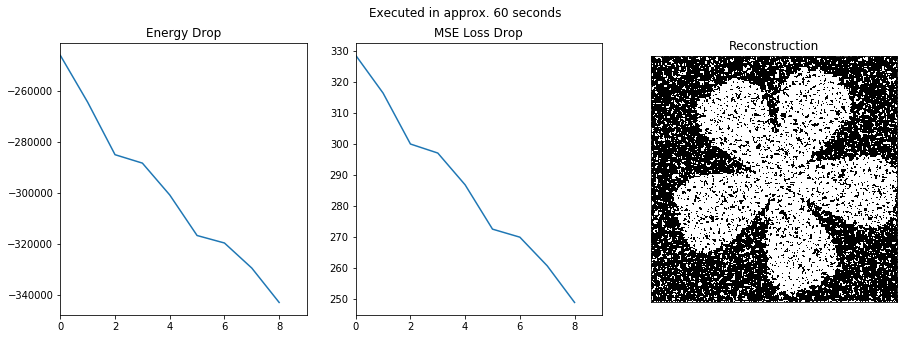

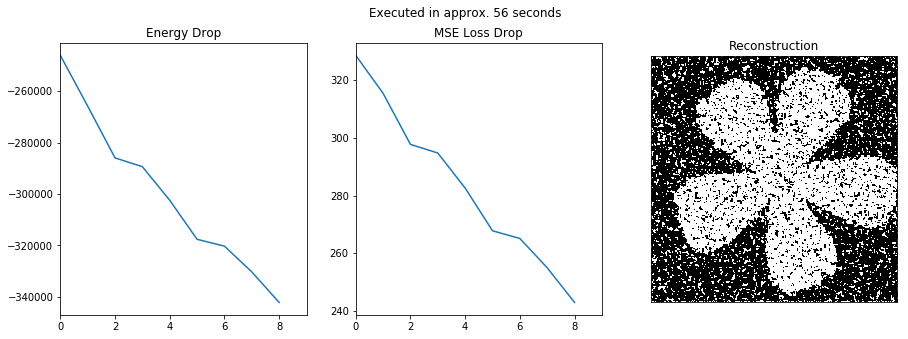

In [23]:
def beta_fcn(fun, iter, N):
    if fun == 'exp': Beta = -2.5+ 3* 2**(iter/N)
    elif fun == 'quad': Beta = 0.5+ 3* ((iter+1) /N)**2
    elif fun == 'linear': Beta = 0.5+ 3* (iter+ 1)/N
    elif fun == 'log': Beta = 0.5+ 0.25* np.log(iter+ 1)
            
    return Beta
    
def your_method(img_noisy_observation, img_original, epochs, n_neighbors, fun):
    """Do the sampling starting from noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    # initialize
    x = img_noisy_observation.copy()
    x_new = img_noisy_observation.copy()
    
    # image size
    Ny, Nx = x.shape
    
    # energies
    energies = []
    e_tracking = energy(x, img_noisy_observation, n_neighbors)
    
    # losses
    losses = []
    
    # sampling       
    for k in range(epochs):
        
        # introduce random walk through image
        perm = np.random.permutation(x.size)[0:int(0.6 * x.size)]
        
        for it, p in enumerate(perm):
            i = int(p/ Nx)
            j = p% Ny
                     
            # copy figure and switch pixels
            x_new[i,j] = -x_new[i,j]    
            
            # calculate neighbors
            neigh = neighbors(i, j, Nx, Ny, n_neighbors)
            min_x = int(np.min(neigh[:, 1]))
            max_x = int(np.max(neigh[:, 1]))
            
            min_y = int(np.min(neigh[:, 0]))
            max_y = int(np.max(neigh[:, 0]))
            
            # local energy calculation
            e1 = energy(x[min_y: max_y, min_x: max_x], img_noisy_observation[min_y: max_y, min_x: max_x], n_neighbors)
            e2 = energy(x_new[min_y: max_y, min_x: max_x], img_noisy_observation[min_y: max_y, min_x: max_x], n_neighbors)
                
            # acceptance probability
            Beta_iter = beta_fcn(fun, it, int(0.6 * x.size))
            
            prob = np.exp(-Beta_iter* max(0, e2-e1))
                
            u= rd.random()
                
            if prob >= u:
                x[i, j] = x_new[i, j]                
                e_tracking = e_tracking + e2 - e1
            else:
                x_new[i, j] = x[i, j]
                
            # calculate total energy every nth iteration    
            if (it)%25000 == 0:
                energies.append(e_tracking)
                losses.append(mse_loss(x, img_original))        
           
    return x, np.asarray(energies), np.asarray(losses)

#
def evaluate2(method, img_noisy_observation, img_original, epochs=1, n_neighbors= 4, fun = 'quad'):
    """ Given a sampling method, we will run the sampling procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
            method (function pointer): sampling method
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
            epochs (int): number of epochs to run the sampling
    """
    # Run specified sampling method
    start_time = time.time()
    img_estimate, energies, losses = method(img_noisy_observation, img_original, epochs, n_neighbors, fun)
    execution_time = time.time() - start_time
    # Plot energy and MSE drop
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    ax1.plot(energies)
    ax1.set_title('Energy Drop')
    ax1.set_xlim(0, int(1.1* len(energies)))
    ax2.plot(losses)
    ax2.set_title('MSE Loss Drop')
    ax2.set_xlim(0, int(1.1* len(losses)))
    ax3.imshow(img_estimate, cmap='gray')
    ax3.set_title('Reconstruction')
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    plt.suptitle("Executed in approx. "+str(int(execution_time)) + " seconds")
    # show plots
    plt.show()

# Evaluate your method
evaluate2(your_method, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 3, 4, 'exp')
evaluate2(your_method, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 3, 4, 'quad')
evaluate2(your_method, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 3, 4, 'linear')
evaluate2(your_method, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 3, 4, 'log')

In this final exercise, different temperature schedulings are investigated for the simulated annealing algorithm. <br>
For convenience, the functions are applied directly to the Beta-coefficient. Following laws were imposed: <br>
Beta ~ 2^(i/N) - exponential<br>
Beta ~ (i/N)^2 - quadratic<br>
Beta ~ i/N - linear<br>
Beta ~ log(i) - logarithmic<br>

where i is the current iteration and N the total number of iterations per epoch. <br>

The best performance in terms of energy drop is observed for the quadratic increase of beta, the worst for the exponential. Quadratic increase seems to have the best trade-off between slow cooling allowing to switch many pixels and fast cooling leading to convergence of the algorithm.

# Extension: sampling from expectations

Solve this for an additional point. Note that solving only this part will give you 0 points, so you need to solve previous problems before doing this one.

## Task

In the image reconstruction problem above we have been trying to identify state with minimal energy i.e. the maximum a posteriori probability.

Another application of MCMC is to compute the expected value of a random variable - as for instance in Restricted Boltzmann Machines (RBMs), which allow for efficient Gibbs Sampling. Please refer to [3] for more details about them, even the code is provided. RBMs played a crucial role in the early development of deep learning (early as 2006 early).

We ask you to implement an RBM using the MNIST data set from last time and apply Locally Linear embedding to the representations obtained from the RBM. Does your embedding get better? You may also try to stack RBMs as described in the reference and see how the embedding changes as you get higher level representations.

It is enough to provide and explain several plots to compare the quality of embeddings of LLE and RBM+LLE models. You may use the sklearn implementation of LLE in case you skipped the previous exercise.

### References

[3] http://deeplearning.net/tutorial/rbm.html

# Extra Comments?

If there is anything that you liked or disliked in this exercise, please let us now by noting that down in the following box. This will help us improve our future exercises. Thank you in advance!